In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
train = pd.read_csv('/content/sales_train.csv')
test = pd.read_csv('/content/test.csv')
shops = pd.read_csv('/content/shops.csv')
items = pd.read_csv('/content/items.csv')
item_categories = pd.read_csv('/content/item_categories.csv')

**Train**

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train.shape

(2935849, 6)

Пустых значений нет

In [5]:
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [6]:
train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [7]:
test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

Все магазины, что есть в test, есть и в train

In [8]:
len(list(set(test.shop_id) - set(train.shop_id)))

0

Не все товары, что есть в test, есть в train

In [9]:
len(list(set(test.item_id) - set(train.item_id)))

363

Добавим новые поля(день месяца, день недели, месяц, год) к модели и сделаем дату индексом

In [48]:
train['date'] = train['date'].astype('datetime64[ns]')
train = train.set_index('date')
train['year'] = train.index.year
train['month'] = train.index.month
train['day'] = train.index.day
train['weekday name'] = train.index.weekday

# **Target**

Распределение количества проданных товаров в день

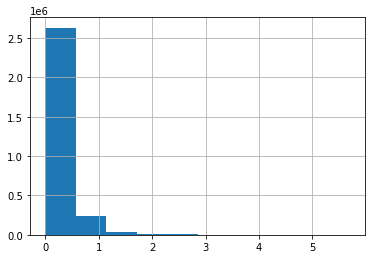

In [ ]:
np.log(train[train['item_cnt_day']>0]['item_cnt_day']).hist()

В большинстве случаев количество проданных товаров = 1

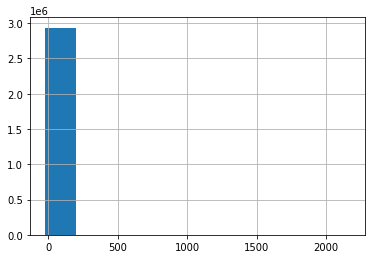

In [ ]:
train['item_cnt_day'].hist()

Есть несколько выбросов

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


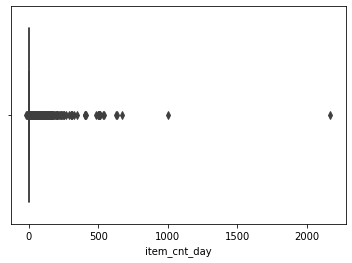

In [ ]:
sns.boxplot(train['item_cnt_day'])

In [ ]:
train = train[train['item_cnt_day'] < 300]

Есть отрицательные значения, при этом нет нулевых. Видна тенденция на уменьшение, поэтому, скорее всего, отрицательные значения не ошибка, а, например, количество возвращенных товаров.



In [12]:
train[train['item_cnt_day'] <= 0].groupby(by='item_cnt_day').agg(['count'])['item_id']

,count
item_cnt_day,
-22.0,1
-16.0,1
-9.0,1
-6.0,2
-5.0,4
-4.0,3
-3.0,14
-2.0,78
-1.0,7252


В 2015 году отрицательных значений уже не было

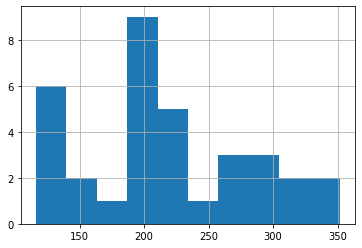

In [14]:
train[train['item_cnt_day'] <= 0].sort_values(by='date')['date_block_num'].value_counts().hist()

Отрицательные значения практически не зависят от магазинов. Что подтверждает неслучайность распределения этих значений.

Количество магазинов

In [ ]:
train['shop_id'].unique().shape

(60,)

Количество магазинов, где были отрицательные значения

In [ ]:
train[train['item_cnt_day'] <= 0]['shop_id'].unique().shape

(54,)

И не зависит от товаров

In [ ]:
train[train['item_cnt_day'] <= 0]['item_id'].shape

(7356,)

In [ ]:
train[train['item_cnt_day'] <= 0]['item_id'].unique().shape

(3511,)

# **Цена**

Есть выбросы

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


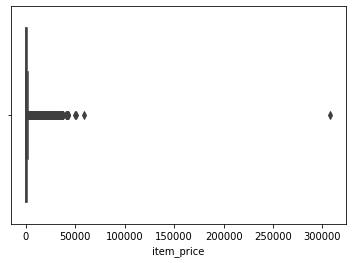

In [15]:
sns.boxplot(train['item_price'])

Удаляем выбросы

In [19]:
train = train[train['item_price']<30000]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


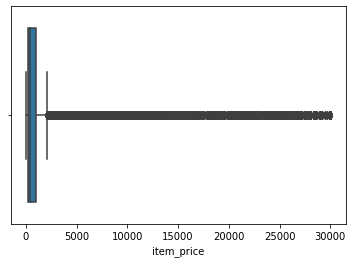

In [17]:
sns.boxplot(train['item_price'])

Чем дешевле товар, тем в среднем больше у него продаж

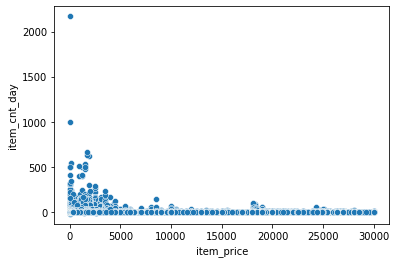

In [20]:
sns.scatterplot(data=train, x="item_price", y="item_cnt_day")

## Продажи по дням

В первый день месяца резкое увеличение продаж. Скорее всего, это не отражает реальные продажи

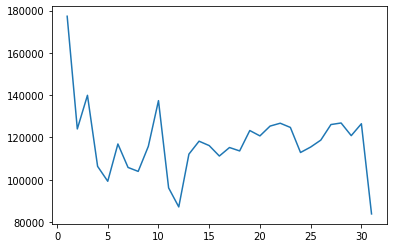

In [ ]:
train_all = train.groupby(by='day')['item_cnt_day'].sum()
plt.plot(train_all)

# Продажи по годам

Виден тренд на снижение продаж

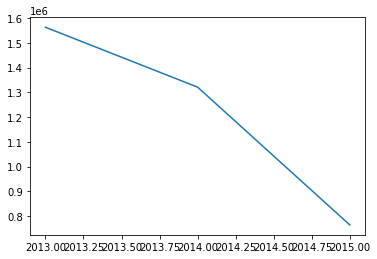

In [ ]:
train_all = train.groupby(by='year')['item_cnt_day'].sum()
plt.plot(train_all)

## Продажи по месяцам

В последний месяц продажи возрастают

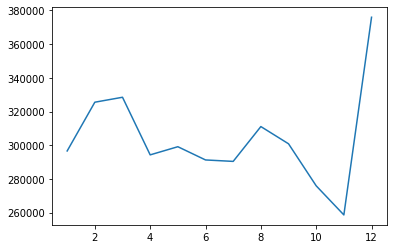

In [ ]:
train_all = train.groupby(by='month')['item_cnt_day'].sum()
plt.plot(train_all)

# Продажи по дням недели

Пик продаж приходится на 5й день

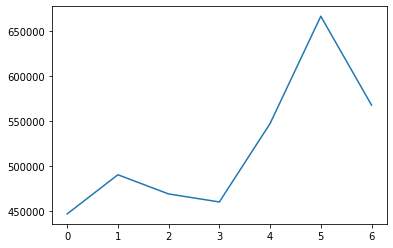

In [ ]:
train_all = train.groupby(by='weekday name')['item_cnt_day'].sum()
plt.plot(train_all)

# Магазины с наибольшими продажами

У магазинов с высокими продажами видны сезонность и тренд

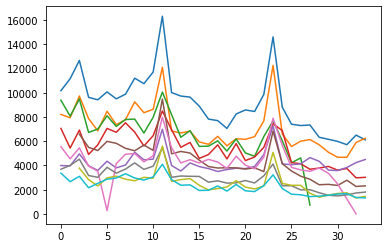

In [ ]:
most_sold_shop = train.groupby(by='shop_id')['item_cnt_day'].sum().sort_values(ascending=False)
most_sold_shop_id = list(most_sold_shop[:10].index)
for id in most_sold_shop_id:
  plt.plot(train[train['shop_id'] == id].groupby(by='date_block_num')['item_cnt_day'].sum())

# Магазины со средними продажами

У магазинов со средними продажами также видны сезонность и тренд, однако, тренд на снижение сильнее, чем у магазинов с высокими продажами

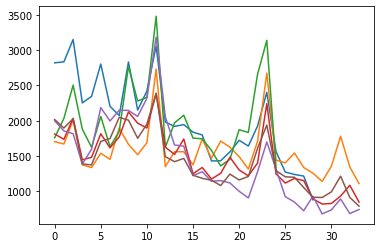

In [ ]:
most_sold_shop_ids = train.groupby(by='shop_id')['item_cnt_day'].sum().sort_values(ascending=False)
most_sold_shop_ids = list(most_sold_shop_ids[27:33].index)
for id in most_sold_shop_ids:
  plt.plot(train[train['shop_id'] == id].groupby(by='date_block_num')['item_cnt_day'].sum())

# Магазины с низкими продажами

Магазины с наименьшими продажами либо только начали продавать, либо уже закончили

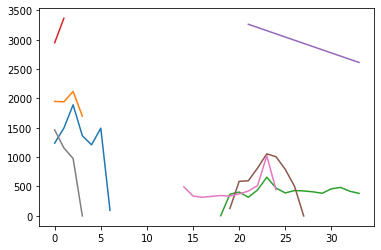

In [39]:
most_sold_shop_ids = train.groupby(by='shop_id')['item_cnt_day'].sum().sort_values(ascending=False)
least_sold_shop_ids = list(most_sold_shop_ids[50:].index)
for id in least_sold_shop_ids:
  plt.plot(train[train['shop_id'] == id].groupby(by='date_block_num')['item_cnt_day'].sum())

Поведение продаж по магазинам, у которых стабильно есть продажи разительно отличается от тех, у кого нет стабильности


При этом только 2 магазина с такими продажами есть в test. 

In [37]:
len(set(test.shop_id.unique())) - len(set(test.shop_id.unique()) - set(least_sold_shop_ids))

2

# Магазины с продажами по конкретному продукту

In [40]:
most_sold_shop_ids_month = train.groupby(by=['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().sort_values(ascending=False)

Процент высоко продаваемых товаров в отдельных магазинах в месяц. Можно сделать вывод, что хорошо продаваемых товаров в выборке немного

In [41]:
print(f"{(len(most_sold_shop_ids_month[most_sold_shop_ids_month > 20]) / len(most_sold_shop_ids_month) * 100):.2f}", "%")

0.71 %


У магазинов с низкими продажами продажи варьируются от 1 до 2

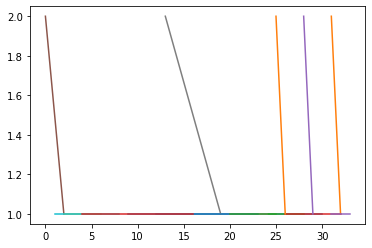

In [ ]:
most_sold_shop_ids = train.groupby(by=['shop_id','item_id'])['item_cnt_day'].sum().sort_values(ascending=False)
least_sold_shop_ids = list(most_sold_shop_ids[200000:200015].index)
for s_id, i_id in least_sold_shop_ids:
  plt.plot(train[(train['shop_id'] == s_id) & (train['item_id'] == i_id)].groupby(by='date_block_num')['item_cnt_day'].sum())
#most_sold_shop_ids.plot()

У магазинов со средними продажами продажи около 5

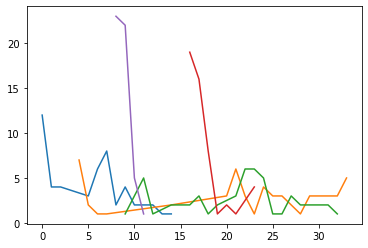

In [ ]:
least_sold_shop_ids = list(most_sold_shop_ids[10000:10005].index)
for s_id, i_id in least_sold_shop_ids:
  plt.plot(train[(train['shop_id'] == s_id) & (train['item_id'] == i_id)].groupby(by='date_block_num')['item_cnt_day'].sum())
#most_sold_shop_ids.plot()

С высокими продажами

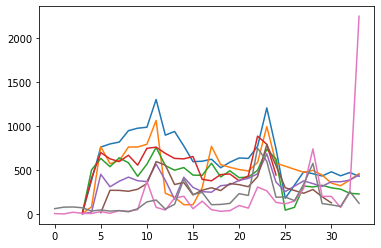

In [ ]:
least_sold_shop_ids = list(most_sold_shop_ids[:8].index)
for s_id, i_id in least_sold_shop_ids:
  plt.plot(train[(train['shop_id'] == s_id) & (train['item_id'] == i_id)].groupby(by='date_block_num')['item_cnt_day'].sum())
#most_sold_shop_ids.plot()

Из графиков и квартилей видно, что большинство продаж - это 1-2 товара в месяц. При этом есть довольно высокие продажи(их немного). 


In [ ]:
most_sold_shop_ids.describe()

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_day, dtype: float64

# Тренд

Используя скользящее среднее можно заметить тренд на снижение

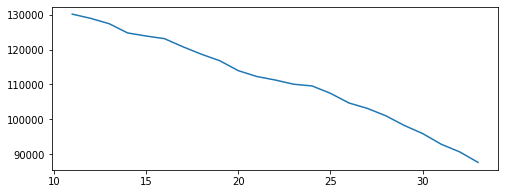

In [ ]:
rolling_mean = total_sales.rolling(window=12).mean()
plt.figure(figsize=(8,3))
plt.plot(rolling_mean)

На зимние месяцы приходится больше всего продаж. Ну и в целом, это даты перед праздниками

In [ ]:
most_sold = train['date_block_num'].value_counts().sort_values(ascending=False)[:5]
for month in most_sold.index:
  print(month, " ", train[train['date_block_num'] == month]['date'][:1])

11   1124316    04.12.2013
Name: date, dtype: object
23   2192637    24.12.2014
Name: date, dtype: object
2   224303    03.03.2013
Name: date, dtype: object
0   0    02.01.2013
Name: date, dtype: object
1   115690    21.02.2013
Name: date, dtype: object


# *Магазины*

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


shop_name содержит название города и название тц через пробел

In [95]:
shop_split = shops['shop_name'].str.split(' ')
shop_city = shop_split.map(lambda x: x[0])
shop_city[shop_city == 'ул. Чкалова 39м²'] = 'ул. Чкалова 39м?'
shop_city[shop_city == 'Орджоникидзе, 56 фран'] = 'Орджоникидзе, 56'
shop_city[shop_city == 'ТРК "Мегацентр Горизонт" Островной'] = 'ТРК "Мегацентр Горизонт"'

In [96]:
shop_name = shop_split.map(lambda x: " ".join(x[1:]))
shops['shop_name'] = shop_name
shops['shop_city'] = shop_city
shops.head()

,shop_name,shop_id,shop_city
0,"Орджоникидзе, 56 фран",0,!Якутск
1,"ТЦ ""Центральный"" фран",1,!Якутск
2,"ТЦ ""Мега""",2,Адыгея
3,"ТРК ""Октябрь-Киномир""",3,Балашиха
4,"ТЦ ""Волга Молл""",4,Волжский


Делаем индексы для магазинов и городов

In [97]:
shs = pd.DataFrame(shops.shop_name.unique(), columns=['shop_name'])
shs['shop_name_id'] = shs.index
shops = shops.merge(shs, on='shop_name')
cts = pd.DataFrame(shops.shop_city.unique(), columns=['shop_city'])
cts['shop_city_id'] = cts.index
shops = shops.merge(cts, on='shop_city')

# Категории

In [99]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


item_category_name содержит 2 категории: более общую и частную

In [100]:
ic_split = item_categories['item_category_name'].str.split(' - ')
category = ic_split.map(lambda x: x[0])
sub_category = ic_split.map(lambda x: x[1] if len(x) == 2 else None)
item_categories['category'] = category
item_categories['sub_category'] = sub_category
item_categories.head()

,item_category_name,item_category_id,category,sub_category
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


Делаем индексы для категорий и подкатегорий

In [101]:
cats = pd.DataFrame(item_categories.category.unique(), columns=['category'])
cats['category_id'] = cats.index
item_categories = item_categories.merge(cats, on='category')
sub_cats = pd.DataFrame(item_categories.sub_category.unique(), columns=['sub_category'])
sub_cats['sub_category_id'] = sub_cats.index
item_categories = item_categories.merge(sub_cats, on='sub_category')

**Correlation**

In [103]:
item_cat_merge = items.merge(item_categories, on='item_category_id')

In [105]:
merged = train.merge(item_cat_merge, on='item_id').drop(columns=['item_name']).reset_index()

Значительных корреляций нет

In [107]:
merged.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,index,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,category_id,sub_category_id
index,1.00,0.58,0.02,0.12,0.14,0.03,0.00,-0.00,0.01
date_block_num,0.58,1.00,0.02,0.01,0.10,0.01,0.03,-0.00,0.03
shop_id,0.02,0.02,1.00,0.03,-0.02,-0.01,0.02,0.03,0.01
item_id,0.12,0.01,0.03,1.00,-0.13,0.02,0.37,0.45,0.34
item_price,0.14,0.10,-0.02,-0.13,1.00,0.01,-0.25,-0.32,-0.21
item_cnt_day,0.03,0.01,-0.01,0.02,0.01,1.00,0.01,-0.00,0.01
item_category_id,0.00,0.03,0.02,0.37,-0.25,0.01,1.00,0.95,0.94
category_id,-0.00,-0.00,0.03,0.45,-0.32,-0.00,0.95,1.00,0.88
sub_category_id,0.01,0.03,0.01,0.34,-0.21,0.01,0.94,0.88,1.00


# Выводы:


*   Количество проданных товаров может быть отрицательно
*   В количестве продаж присутствует тренд на снижение
*   Все магазины, что есть в test, есть и в train
*   В test есть некоторые товары, которых нет в train
*   В начале месяца резкое увеличение продаж
*   В конце года продажи резко увеличиваются
*   Продажи увеличиваются на 5й день недели
*   Новый пункт








# **Cross validation**

Кроссвалидацию используем специальную для временных рядов, которая будет делить выборку в учетом времени

In [49]:
from sklearn.model_selection import TimeSeriesSplit

test = train['item_cnt_day']
train = train.drop(columns=['item_cnt_day'])
train = train.sort_index()

In [ ]:
cv = TimeSeriesSplit(n_splits=5).split(train)